Data processing part is inspired by Serigne's notebook:
https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard

# Setting up

In [1]:
import os
os.chdir("../")
os.getcwd()

'/Users/bryskulov/Desktop/Projects/house_prices'

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [96]:
import numpy as np 
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

from scipy import stats
from scipy.stats import norm, skew

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction import DictVectorizer

import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

import pickle

In [44]:
RANDOM_SEED = 42
MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"

In [45]:
import mlflow
from mlflow.tracking import MlflowClient

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

In [46]:
#mlflow.create_experiment("house-price-prediction")
mlflow.set_experiment("house-price-prediction")

<Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='house-price-prediction', tags={}>

In [47]:
client.list_experiments()

[<Experiment: artifact_location='./mlruns/0', experiment_id='0', lifecycle_stage='active', name='Default', tags={}>,
 <Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='house-price-prediction', tags={}>]

# Data Loading

In [48]:
# Reading datasets
train = pd.read_csv('data/train.csv')

In [49]:
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [50]:
#check the numbers of samples and features
print(f"The train data size before dropping Id feature is : {train.shape} ")

#Save the 'Id' column
train_ID = train['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)

The train data size before dropping Id feature is : (1460, 81) 


# Data processing

## Outliers

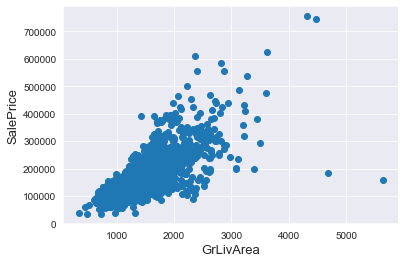

In [51]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In [52]:
#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

## Target variable

In [53]:
def plot_distribution(series):
    sns.distplot(series, fit=norm);

    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(series)
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

    #Now plot the distribution
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    plt.ylabel('Frequency')
    plt.title('Distribution')

    #Get also the QQ-plot
    fig = plt.figure()
    res = stats.probplot(series, plot=plt)
    plt.show()


 mu = 180932.92 and sigma = 79467.79



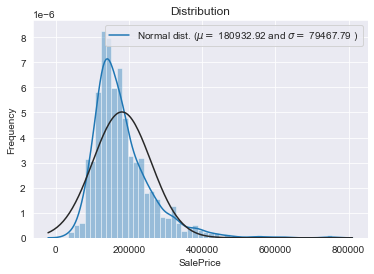

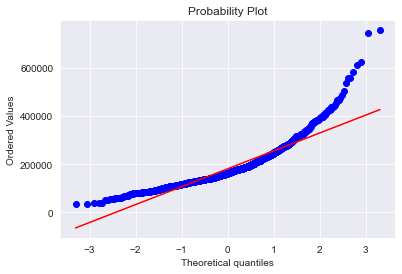

In [54]:
plot_distribution(train['SalePrice'])

In [55]:
# I don't need to normalize the target variable, since I will use boosting methods

In [56]:
train_label = train.SalePrice.values
train.drop(['SalePrice'], axis=1, inplace=True)
print("train size is : {}".format(train.shape))

train size is : (1458, 79)


## Missing data

In [57]:
train_na = (train.isnull().sum() / len(train)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :train_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.588477
MiscFeature,96.296296
Alley,93.758573
Fence,80.727023
FireplaceQu,47.325103
LotFrontage,17.764060
GarageType,5.555556
GarageYrBlt,5.555556
GarageFinish,5.555556
GarageQual,5.555556


### Imputing missing values manually

In [58]:
# Don't use this, I leave it to the boosting algorithm

In [59]:
# #Replacing with None
# train["PoolQC"] = train["PoolQC"].fillna("None")
# train["MiscFeature"] = train["MiscFeature"].fillna("None")
# train["Alley"] = train["Alley"].fillna("None")
# train["Fence"] = train["Fence"].fillna("None")
# train["FireplaceQu"] = train["FireplaceQu"].fillna("None")

# #Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
# train["LotFrontage"] = train.groupby("Neighborhood")["LotFrontage"].transform(
#     lambda x: x.fillna(x.median()))

# for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
#     train[col] = train[col].fillna('None')
    
# for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
#     train[col] = train[col].fillna(0)
    
# for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
#     train[col] = train[col].fillna(0)
    
# for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
#     train[col] = train[col].fillna('None')
    
# train["MasVnrType"] = train["MasVnrType"].fillna("None")
# train["MasVnrArea"] = train["MasVnrArea"].fillna(0)

# train['MSZoning'] = train['MSZoning'].fillna(train['MSZoning'].mode()[0])

# train = train.drop(['Utilities'], axis=1)
# train["Functional"] = train["Functional"].fillna("Typ")
# train['Electrical'] = train['Electrical'].fillna(train['Electrical'].mode()[0])
# train['KitchenQual'] = train['KitchenQual'].fillna(train['KitchenQual'].mode()[0])
# train['Exterior1st'] = train['Exterior1st'].fillna(train['Exterior1st'].mode()[0])
# train['Exterior2nd'] = train['Exterior2nd'].fillna(train['Exterior2nd'].mode()[0])
# train['SaleType'] = train['SaleType'].fillna(train['SaleType'].mode()[0])
# train['MSSubClass'] = train['MSSubClass'].fillna("None")

In [60]:
# #Check remaining missing values if any 
# train_na = (train.isnull().sum() / len(train)) * 100
# train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)
# missing_data = pd.DataFrame({'Missing Ratio' :train_na})
# missing_data.head(20)

## Adding one more important feature

In [61]:
train['TotalSF'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']

## Transforming numerical to categorical

In [62]:
num_to_categ_cols = ['MSSubClass', 'OverallCond', 'YrSold', 'MoSold']
train[num_to_categ_cols] = train[num_to_cat_cols].astype(str)

In [63]:
df_dict = train.to_dict("records")
dv = DictVectorizer(sparse=True)
train = dv.fit_transform(df_dict)
print(train.shape)

(1458, 341)


# Modelling

## XGBoost

## KFold run with Serigne's parameters

In [70]:
#Validation function
n_folds = 5

def rmsle_cv(model):     
    kf = KFold(n_folds, shuffle=True, random_state=RANDOM_SEED).get_n_splits(train)
    rmse= np.sqrt(-cross_val_score(model, train, train_label, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [71]:
params = {
    'colsample_bytree': 0.4603, 
    'gamma': 0.0468, 
    'learning_rate': 0.05, 
    'max_depth': 3, 
    'min_child_weight': 1.7817, 
    'n_estimators': 2200,
    'reg_alpha': 0.4640, 
    'reg_lambda': 0.8571,
    'subsample': 0.5213,
    'random_state': 7, 
    'nthread': -1,
}

In [72]:
model_xgb = xgb.XGBRegressor(**params)
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 22047.2418 (2291.3676)



## Running a specific model on train/test split

In [73]:
# I split the data in 80:10:10 for train:valid:test dataset

X_train, X_rem, y_train, y_rem = train_test_split(train, train_label, train_size=0.8, random_state=RANDOM_SEED)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=RANDOM_SEED)

print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(1166, 341)
(1166,)
(146, 341)
(146,)
(146, 341)
(146,)


(None, None)

In [74]:
XGBOOST_AUTOLOG_DISABLE = True
def run_xgboost(model, data_tag):
    mlflow.xgboost.autolog(disable=XGBOOST_AUTOLOG_DISABLE)
    with mlflow.start_run():
        if XGBOOST_AUTOLOG_DISABLE:
            mlflow.set_tag('developer', 'bryskulov')
            mlflow.set_tag("model", "xgboost")
            mlflow.set_tag('data', data_tag)
            mlflow.log_params(model.get_xgb_params())
        else:            
            pass
        model.fit(X_train, y_train)
        y_pred = model_xgb.predict(X_test)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        mlflow.log_metric('rmse', rmse)
    return rmse

In [75]:
data_tag = 'without normalization, handling missing values, adjusting skewness'
run_xgboost(model_xgb, data_tag)

21826.874174445245

In [76]:
mlflow.xgboost.log_model(model_xgb, artifact_path="models")

ModelInfo(artifact_path='models', flavors={'python_function': {'loader_module': 'mlflow.xgboost', 'python_version': '3.9.10', 'data': 'model.xgb', 'env': 'conda.yaml'}, 'xgboost': {'xgb_version': '1.6.1', 'data': 'model.xgb', 'model_class': 'xgboost.sklearn.XGBRegressor', 'code': None}}, model_uri='runs:/2f4587aacd004393a7f906560fab3757/models', model_uuid='73350c89b1664092823c9c8d433e4217', run_id='2f4587aacd004393a7f906560fab3757', saved_input_example_info=None, signature_dict=None, utc_time_created='2022-08-08 08:27:10.159519', mlflow_version='1.27.0')

# HYPEROPT

In [77]:
train_xgb = xgb.DMatrix(X_train, label=y_train)
valid_xgb = xgb.DMatrix(X_valid, label=y_valid)
test_xgb = xgb.DMatrix(X_test, label=y_test)

def objective(params):
    mlflow.xgboost.autolog(disable=XGBOOST_AUTOLOG_DISABLE)
    with mlflow.start_run():
        mlflow.set_tag('developer', 'bryskulov')
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        
        model_xgb = xgb.train(
            params=params,
            dtrain=train_xgb,
            evals=[(valid_xgb, 'validation')],
            num_boost_round=2200,
            early_stopping_rounds=50)
        
        y_pred = model_xgb.predict(test_xgb)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [78]:
search_space = {
    'gamma': hp.loguniform('gamma', -5, -1),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.3,1),
    'subsample': hp.uniform('subsample', 0.4,1),
    'max_depth': scope.int(hp.quniform('max_depth', 3, 10, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': RANDOM_SEED
}

In [81]:
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[10:28:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:187105.52763                                                         
[1]	validation-rmse:175454.88570                                                         
[2]	validation-rmse:164056.83694                                                         
[3]	validation-rmse:153797.58849                                                         
[4]	validation-rmse:143973.59130                                                         
[5]	validation-rmse:134867.59837                                                         
[6]	validation-rmse:126184.07007                                                         
[7]	validation-rmse:118401.09767                                                         
[8]	validation-rmse:111389.16339                                        

[88]	validation-rmse:21533.54945                                                         
[89]	validation-rmse:21520.06310                                                         
[90]	validation-rmse:21467.92979                                                         
[91]	validation-rmse:21449.08605                                                         
[92]	validation-rmse:21445.06685                                                         
[93]	validation-rmse:21429.39063                                                         
[94]	validation-rmse:21419.16910                                                         
[95]	validation-rmse:21404.92510                                                         
[96]	validation-rmse:21390.85580                                                         
[97]	validation-rmse:21383.36912                                                         
[98]	validation-rmse:21365.42819                                                         
[99]	valid

[179]	validation-rmse:20867.48161                                                        
[180]	validation-rmse:20854.79861                                                        
[181]	validation-rmse:20842.45363                                                        
[182]	validation-rmse:20832.21634                                                        
[183]	validation-rmse:20839.03712                                                        
[184]	validation-rmse:20840.94800                                                        
[185]	validation-rmse:20854.22405                                                        
[186]	validation-rmse:20861.49672                                                        
[187]	validation-rmse:20863.02813                                                        
[188]	validation-rmse:20875.14820                                                        
[189]	validation-rmse:20878.67187                                                        
[190]	vali

[35]	validation-rmse:22653.01076                                                         
[36]	validation-rmse:22631.38674                                                         
[37]	validation-rmse:22563.27262                                                         
[38]	validation-rmse:22500.64399                                                         
[39]	validation-rmse:22403.42665                                                         
[40]	validation-rmse:22332.08823                                                         
[41]	validation-rmse:22249.93580                                                         
[42]	validation-rmse:22141.30057                                                         
[43]	validation-rmse:22192.26964                                                         
[44]	validation-rmse:22208.60080                                                         
[45]	validation-rmse:22226.28244                                                         
[46]	valid

[22]	validation-rmse:27128.26804                                                         
[23]	validation-rmse:27133.44522                                                         
[24]	validation-rmse:27088.47988                                                         
[25]	validation-rmse:27211.52424                                                         
[26]	validation-rmse:27029.37902                                                         
[27]	validation-rmse:27014.52627                                                         
[28]	validation-rmse:26955.42952                                                         
[29]	validation-rmse:26869.41704                                                         
[30]	validation-rmse:26660.66016                                                         
[31]	validation-rmse:26552.84683                                                         
[32]	validation-rmse:26360.29186                                                         
[33]	valid

[26]	validation-rmse:41734.59357                                                         
[27]	validation-rmse:39793.77669                                                         
[28]	validation-rmse:38180.18057                                                         
[29]	validation-rmse:36662.83337                                                         
[30]	validation-rmse:35128.48275                                                         
[31]	validation-rmse:34094.54937                                                         
[32]	validation-rmse:32937.88370                                                         
[33]	validation-rmse:31750.12477                                                         
[34]	validation-rmse:30772.26005                                                         
[35]	validation-rmse:29805.14745                                                         
[36]	validation-rmse:28981.87778                                                         
[37]	valid

[117]	validation-rmse:19833.43514                                                        
[118]	validation-rmse:19820.87081                                                        
[119]	validation-rmse:19832.21977                                                        
[120]	validation-rmse:19751.14020                                                        
[121]	validation-rmse:19742.15738                                                        
[122]	validation-rmse:19733.42279                                                        
[123]	validation-rmse:19732.47754                                                        
[124]	validation-rmse:19706.42479                                                        
[125]	validation-rmse:19689.80323                                                        
[126]	validation-rmse:19596.27936                                                        
[127]	validation-rmse:19598.96938                                                        
[128]	vali

[208]	validation-rmse:19307.93192                                                        
[209]	validation-rmse:19310.54876                                                        
[210]	validation-rmse:19334.28085                                                        
[211]	validation-rmse:19336.67297                                                        
[212]	validation-rmse:19319.76080                                                        
[213]	validation-rmse:19312.22964                                                        
[214]	validation-rmse:19304.29294                                                        
[215]	validation-rmse:19302.01736                                                        
[216]	validation-rmse:19327.44395                                                        
[217]	validation-rmse:19331.83156                                                        
[218]	validation-rmse:19342.03642                                                        
[219]	vali

[299]	validation-rmse:19021.01940                                                        
[300]	validation-rmse:18992.07975                                                        
[301]	validation-rmse:19012.95241                                                        
[302]	validation-rmse:19018.58582                                                        
[303]	validation-rmse:19034.09792                                                        
[304]	validation-rmse:19034.81827                                                        
[305]	validation-rmse:19024.26048                                                        
[306]	validation-rmse:19017.22629                                                        
[10:28:26] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:185111.06388                                        

[80]	validation-rmse:20350.71365                                                         
[81]	validation-rmse:20339.17305                                                         
[82]	validation-rmse:20340.65089                                                         
[83]	validation-rmse:20340.88365                                                         
[84]	validation-rmse:20317.84859                                                         
[85]	validation-rmse:20326.20699                                                         
[86]	validation-rmse:20350.82169                                                         
[87]	validation-rmse:20350.06902                                                         
[88]	validation-rmse:20335.14203                                                         
[89]	validation-rmse:20337.34639                                                         
[90]	validation-rmse:20377.69623                                                         
[91]	valid

[34]	validation-rmse:42861.78325                                                         
[35]	validation-rmse:42780.19430                                                         
[36]	validation-rmse:42719.94974                                                         
[37]	validation-rmse:43333.16560                                                         
[38]	validation-rmse:42932.46857                                                         
[39]	validation-rmse:43078.50689                                                         
[40]	validation-rmse:42367.00902                                                         
[41]	validation-rmse:42216.89693                                                         
[42]	validation-rmse:42343.43094                                                         
[43]	validation-rmse:42432.48649                                                         
[44]	validation-rmse:42546.87602                                                         
[45]	valid

[55]	validation-rmse:19611.32932                                                         
[56]	validation-rmse:19646.91633                                                         
[57]	validation-rmse:19641.68256                                                         
[58]	validation-rmse:19729.28396                                                         
[59]	validation-rmse:19745.77861                                                         
[60]	validation-rmse:19778.33509                                                         
[61]	validation-rmse:19785.03351                                                         
[62]	validation-rmse:19789.52481                                                         
[63]	validation-rmse:19766.94570                                                         
[64]	validation-rmse:19771.48503                                                         
[65]	validation-rmse:19832.90043                                                         
[66]	valid

[146]	validation-rmse:19332.67342                                                        
[147]	validation-rmse:19377.28168                                                        
[148]	validation-rmse:19368.68236                                                        
[149]	validation-rmse:19365.31054                                                        
[150]	validation-rmse:19370.33847                                                        
[151]	validation-rmse:19370.31945                                                        
[152]	validation-rmse:19387.07792                                                        
[153]	validation-rmse:19367.46040                                                        
[154]	validation-rmse:19395.45499                                                        
[155]	validation-rmse:19415.97882                                                        
[156]	validation-rmse:19386.06832                                                        
[157]	vali

[53]	validation-rmse:26122.69286                                                         
[54]	validation-rmse:26124.63756                                                         
[55]	validation-rmse:26122.24853                                                         
[56]	validation-rmse:26122.35045                                                         
[10:28:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:189846.60571                                                         
[1]	validation-rmse:179521.26660                                                         
[2]	validation-rmse:170011.65040                                                         
[3]	validation-rmse:161276.44218                                                         
[4]	validation-rmse:152940.92412                                        

[84]	validation-rmse:20716.99658                                                         
[85]	validation-rmse:20822.64920                                                         
[86]	validation-rmse:20818.62678                                                         
[87]	validation-rmse:20851.24817                                                         
[88]	validation-rmse:20823.20361                                                         
[89]	validation-rmse:20828.07929                                                         
[90]	validation-rmse:20768.09425                                                         
[91]	validation-rmse:20796.77110                                                         
[92]	validation-rmse:20753.44914                                                         
[93]	validation-rmse:20798.87631                                                         
[94]	validation-rmse:20776.99584                                                         
[95]	valid

[175]	validation-rmse:20974.25485                                                        
[176]	validation-rmse:20937.03827                                                        
[10:28:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:188120.61953                                                         
[1]	validation-rmse:176831.25191                                                         
[2]	validation-rmse:165911.81828                                                         
[3]	validation-rmse:155931.57000                                                         
[4]	validation-rmse:146477.94987                                                         
[5]	validation-rmse:137728.56473                                                         
[6]	validation-rmse:129364.18437                                        

[86]	validation-rmse:21827.01053                                                         
[87]	validation-rmse:21827.56236                                                         
[88]	validation-rmse:21830.85452                                                         
[89]	validation-rmse:21830.71623                                                         
[90]	validation-rmse:21797.86519                                                         
[91]	validation-rmse:21797.45209                                                         
[92]	validation-rmse:21792.63584                                                         
[93]	validation-rmse:21799.86497                                                         
[94]	validation-rmse:21803.23088                                                         
[95]	validation-rmse:21788.75444                                                         
[96]	validation-rmse:21790.12769                                                         
[97]	valid

[0]	validation-rmse:157399.61077                                                         
[1]	validation-rmse:123692.51198                                                         
[2]	validation-rmse:97232.37767                                                          
[3]	validation-rmse:77912.43112                                                          
[4]	validation-rmse:62918.58383                                                          
[5]	validation-rmse:51675.59006                                                          
[6]	validation-rmse:43075.82517                                                          
[7]	validation-rmse:37079.89974                                                          
[8]	validation-rmse:32848.69261                                                          
[9]	validation-rmse:29933.04252                                                          
[10]	validation-rmse:28072.52558                                                         
[11]	valid

[7]	validation-rmse:42031.36481                                                          
[8]	validation-rmse:42166.51415                                                          
[9]	validation-rmse:41911.04651                                                          
[10]	validation-rmse:42318.67164                                                         
[11]	validation-rmse:41954.66962                                                         
[12]	validation-rmse:41948.70739                                                         
[13]	validation-rmse:41992.67990                                                         
[14]	validation-rmse:42419.19345                                                         
[15]	validation-rmse:42463.00390                                                         
[16]	validation-rmse:42542.49423                                                         
[17]	validation-rmse:42674.67431                                                         
[18]	valid

[39]	validation-rmse:21079.86864                                                         
[40]	validation-rmse:21058.15379                                                         
[41]	validation-rmse:21152.52974                                                         
[42]	validation-rmse:21129.65664                                                         
[43]	validation-rmse:21208.82154                                                         
[44]	validation-rmse:21238.93584                                                         
[45]	validation-rmse:21247.72460                                                         
[46]	validation-rmse:21315.09130                                                         
[47]	validation-rmse:21420.21340                                                         
[48]	validation-rmse:21338.91976                                                         
[49]	validation-rmse:21402.54096                                                         
[50]	valid

[52]	validation-rmse:21901.36088                                                         
[53]	validation-rmse:21979.42827                                                         
[54]	validation-rmse:21964.49063                                                         
[55]	validation-rmse:21642.94828                                                         
[56]	validation-rmse:21876.56896                                                         
[57]	validation-rmse:22080.55826                                                         
[58]	validation-rmse:22165.25242                                                         
[59]	validation-rmse:22112.48697                                                         
[60]	validation-rmse:21982.47164                                                         
[61]	validation-rmse:21939.00833                                                         
[62]	validation-rmse:21809.73296                                                         
[63]	valid

[16]	validation-rmse:30425.04543                                                         
[17]	validation-rmse:30614.53638                                                         
[18]	validation-rmse:30523.48849                                                         
[19]	validation-rmse:30230.55071                                                         
[20]	validation-rmse:30267.69699                                                         
[21]	validation-rmse:30217.93020                                                         
[22]	validation-rmse:30401.05280                                                         
[23]	validation-rmse:30349.97105                                                         
[24]	validation-rmse:30380.13749                                                         
[25]	validation-rmse:30294.01842                                                         
[26]	validation-rmse:30177.18356                                                         
[27]	valid

[49]	validation-rmse:21454.59178                                                         
[50]	validation-rmse:21363.60428                                                         
[51]	validation-rmse:21268.62176                                                         
[52]	validation-rmse:21212.07018                                                         
[53]	validation-rmse:21262.44206                                                         
[54]	validation-rmse:21201.56905                                                         
[55]	validation-rmse:21165.91882                                                         
[56]	validation-rmse:21350.23959                                                         
[57]	validation-rmse:21339.92743                                                         
[58]	validation-rmse:21364.51645                                                         
[59]	validation-rmse:21412.39465                                                         
[60]	valid

[12]	validation-rmse:30642.91690                                                         
[13]	validation-rmse:30820.84418                                                         
[14]	validation-rmse:30607.81868                                                         
[15]	validation-rmse:30514.41698                                                         
[16]	validation-rmse:30569.64167                                                         
[17]	validation-rmse:30529.34159                                                         
[18]	validation-rmse:30771.14566                                                         
[19]	validation-rmse:30471.03944                                                         
[20]	validation-rmse:30716.50094                                                         
[21]	validation-rmse:30414.05884                                                         
[22]	validation-rmse:30351.21143                                                         
[23]	valid

[45]	validation-rmse:34034.70951                                                         
[46]	validation-rmse:34031.57338                                                         
[47]	validation-rmse:34008.01473                                                         
[48]	validation-rmse:34082.70035                                                         
[49]	validation-rmse:34129.29715                                                         
[50]	validation-rmse:34270.57009                                                         
[51]	validation-rmse:34298.23407                                                         
[52]	validation-rmse:34236.45112                                                         
[53]	validation-rmse:34170.18429                                                         
[54]	validation-rmse:34109.60387                                                         
[55]	validation-rmse:34145.64432                                                         
[56]	valid

[74]	validation-rmse:23020.60966                                                         
[75]	validation-rmse:23086.99828                                                         
[76]	validation-rmse:23306.46866                                                         
[77]	validation-rmse:23163.20157                                                         
[78]	validation-rmse:23223.86939                                                         
[79]	validation-rmse:23415.07122                                                         
[80]	validation-rmse:23333.89066                                                         
[81]	validation-rmse:23176.40380                                                         
[82]	validation-rmse:23009.55098                                                         
[83]	validation-rmse:23086.20241                                                         
[84]	validation-rmse:23040.98725                                                         
[85]	valid

[12]	validation-rmse:30614.57830                                                         
[13]	validation-rmse:30092.96531                                                         
[14]	validation-rmse:30512.71994                                                         
[15]	validation-rmse:31552.28162                                                         
[16]	validation-rmse:30912.87626                                                         
[17]	validation-rmse:31868.37868                                                         
[18]	validation-rmse:31931.72207                                                         
[19]	validation-rmse:32831.46945                                                         
[20]	validation-rmse:34087.39314                                                         
[21]	validation-rmse:33323.50588                                                         
[22]	validation-rmse:33346.54858                                                         
[23]	valid

[37]	validation-rmse:22532.23480                                                         
[38]	validation-rmse:22257.26112                                                         
[39]	validation-rmse:22297.71034                                                         
[40]	validation-rmse:22168.90457                                                         
[41]	validation-rmse:22077.91314                                                         
[42]	validation-rmse:22087.47441                                                         
[43]	validation-rmse:22151.30664                                                         
[44]	validation-rmse:22286.19497                                                         
[45]	validation-rmse:22280.99980                                                         
[46]	validation-rmse:22208.89555                                                         
[47]	validation-rmse:22326.05369                                                         
[48]	valid

[34]	validation-rmse:24750.95662                                                         
[35]	validation-rmse:24840.35205                                                         
[36]	validation-rmse:24985.83249                                                         
[37]	validation-rmse:24897.14829                                                         
[38]	validation-rmse:24914.11354                                                         
[39]	validation-rmse:24902.09849                                                         
[40]	validation-rmse:24931.10558                                                         
[41]	validation-rmse:24861.10840                                                         
[42]	validation-rmse:24710.47676                                                         
[43]	validation-rmse:24772.54300                                                         
[44]	validation-rmse:24660.45595                                                         
[45]	valid

[64]	validation-rmse:23506.45650                                                         
[65]	validation-rmse:23548.79728                                                         
[66]	validation-rmse:23454.67814                                                         
[67]	validation-rmse:23416.12255                                                         
[68]	validation-rmse:23446.09928                                                         
[69]	validation-rmse:23354.26707                                                         
[70]	validation-rmse:23379.42760                                                         
[71]	validation-rmse:23431.76400                                                         
[72]	validation-rmse:23383.21971                                                         
[10:28:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of 

[14]	validation-rmse:47458.45098                                                         
[15]	validation-rmse:43915.28806                                                         
[16]	validation-rmse:40476.76205                                                         
[17]	validation-rmse:37908.21779                                                         
[18]	validation-rmse:35370.34204                                                         
[19]	validation-rmse:33220.35369                                                         
[20]	validation-rmse:31401.97435                                                         
[21]	validation-rmse:29853.28538                                                         
[22]	validation-rmse:28350.06755                                                         
[23]	validation-rmse:27325.21997                                                         
[24]	validation-rmse:26457.07743                                                         
[25]	valid

[105]	validation-rmse:19011.37274                                                        
[106]	validation-rmse:18994.45626                                                        
[107]	validation-rmse:19051.26672                                                        
[108]	validation-rmse:19058.95334                                                        
[109]	validation-rmse:19059.13710                                                        
[110]	validation-rmse:19035.46226                                                        
[111]	validation-rmse:18963.24880                                                        
[112]	validation-rmse:19027.92449                                                        
[113]	validation-rmse:19031.28497                                                        
[114]	validation-rmse:19032.65670                                                        
[115]	validation-rmse:19050.61648                                                        
[116]	vali

[31]	validation-rmse:22092.15274                                                         
[32]	validation-rmse:22004.69425                                                         
[33]	validation-rmse:22223.25358                                                         
[34]	validation-rmse:22097.97437                                                         
[35]	validation-rmse:22225.63765                                                         
[36]	validation-rmse:22026.05193                                                         
[37]	validation-rmse:22171.85713                                                         
[38]	validation-rmse:22353.55163                                                         
[39]	validation-rmse:22339.35947                                                         
[40]	validation-rmse:22098.73165                                                         
[41]	validation-rmse:22111.76520                                                         
[42]	valid

[122]	validation-rmse:21467.24149                                                        
[123]	validation-rmse:21416.83876                                                        
[124]	validation-rmse:21391.14484                                                        
[125]	validation-rmse:21393.98501                                                        
[126]	validation-rmse:21417.79421                                                        
[127]	validation-rmse:21369.15478                                                        
[128]	validation-rmse:21431.23513                                                        
[129]	validation-rmse:21465.76344                                                        
[130]	validation-rmse:21534.85746                                                        
[131]	validation-rmse:21566.17234                                                        
[132]	validation-rmse:21604.46248                                                        
[133]	vali

[213]	validation-rmse:21035.24908                                                        
[214]	validation-rmse:21090.55046                                                        
[215]	validation-rmse:21102.71363                                                        
[216]	validation-rmse:21090.23239                                                        
[217]	validation-rmse:21110.07219                                                        
[218]	validation-rmse:21147.86865                                                        
[219]	validation-rmse:21098.73530                                                        
[220]	validation-rmse:21066.91994                                                        
[221]	validation-rmse:21055.24113                                                        
[222]	validation-rmse:21137.62351                                                        
[223]	validation-rmse:21201.39966                                                        
[224]	vali

[44]	validation-rmse:28008.23537                                                         
[45]	validation-rmse:27997.55723                                                         
[46]	validation-rmse:27967.61256                                                         
[47]	validation-rmse:27972.51213                                                         
[48]	validation-rmse:27869.53935                                                         
[49]	validation-rmse:27880.89719                                                         
[50]	validation-rmse:27891.71410                                                         
[51]	validation-rmse:27912.41622                                                         
[52]	validation-rmse:27845.86458                                                         
[53]	validation-rmse:27840.92575                                                         
[54]	validation-rmse:27779.64345                                                         
[55]	valid

[69]	validation-rmse:19474.39537                                                         
[70]	validation-rmse:19463.29339                                                         
[71]	validation-rmse:19442.85192                                                         
[72]	validation-rmse:19504.85578                                                         
[73]	validation-rmse:19470.59635                                                         
[74]	validation-rmse:19467.62719                                                         
[75]	validation-rmse:19506.35457                                                         
[76]	validation-rmse:19514.79206                                                         
[77]	validation-rmse:19539.46127                                                         
[78]	validation-rmse:19461.16217                                                         
[79]	validation-rmse:19455.12666                                                         
[80]	valid

[9]	validation-rmse:89303.64328                                                          
[10]	validation-rmse:82662.48522                                                         
[11]	validation-rmse:76427.90542                                                         
[12]	validation-rmse:70865.36451                                                         
[13]	validation-rmse:65352.64258                                                         
[14]	validation-rmse:60649.68848                                                         
[15]	validation-rmse:56532.42710                                                         
[16]	validation-rmse:52706.67240                                                         
[17]	validation-rmse:49137.05131                                                         
[18]	validation-rmse:46036.82503                                                         
[19]	validation-rmse:43258.75580                                                         
[20]	valid

[0]	validation-rmse:118574.10411                                                         
[1]	validation-rmse:72452.16138                                                          
[2]	validation-rmse:47259.20325                                                          
[3]	validation-rmse:35983.74066                                                          
[4]	validation-rmse:30961.48612                                                          
[5]	validation-rmse:31141.76518                                                          
[6]	validation-rmse:32347.23628                                                          
[7]	validation-rmse:32299.14913                                                          
[8]	validation-rmse:33428.01875                                                          
[9]	validation-rmse:34238.03344                                                          
[10]	validation-rmse:33914.22967                                                         
[11]	valid

[34]	validation-rmse:26064.01966                                                         
[35]	validation-rmse:25997.97844                                                         
[36]	validation-rmse:26005.47622                                                         
[37]	validation-rmse:26006.10113                                                         
[38]	validation-rmse:26026.64050                                                         
[39]	validation-rmse:26038.95171                                                         
[40]	validation-rmse:26033.42460                                                         
[41]	validation-rmse:25952.52645                                                         
[42]	validation-rmse:25921.37564                                                         
[43]	validation-rmse:25895.93500                                                         
[44]	validation-rmse:25882.74894                                                         
[45]	valid

[50]	validation-rmse:20076.83378                                                         
[51]	validation-rmse:20145.42724                                                         
[52]	validation-rmse:20017.52117                                                         
[53]	validation-rmse:20081.08088                                                         
[54]	validation-rmse:20173.62820                                                         
[55]	validation-rmse:20128.11201                                                         
[56]	validation-rmse:20145.33845                                                         
[57]	validation-rmse:20197.76140                                                         
[58]	validation-rmse:20143.67646                                                         
[59]	validation-rmse:20227.80533                                                         
[60]	validation-rmse:20211.53378                                                         
[61]	valid

[35]	validation-rmse:22957.69976                                                         
[36]	validation-rmse:22684.90581                                                         
[37]	validation-rmse:22504.90182                                                         
[38]	validation-rmse:22289.07415                                                         
[39]	validation-rmse:22136.84887                                                         
[40]	validation-rmse:21990.19749                                                         
[41]	validation-rmse:21879.32594                                                         
[42]	validation-rmse:21782.31158                                                         
[43]	validation-rmse:21655.47302                                                         
[44]	validation-rmse:21616.67423                                                         
[45]	validation-rmse:21485.62869                                                         
[46]	valid

[12]	validation-rmse:98423.45738                                                         
[13]	validation-rmse:93387.83271                                                         
[14]	validation-rmse:88505.14994                                                         
[15]	validation-rmse:83939.21232                                                         
[16]	validation-rmse:79807.43595                                                         
[17]	validation-rmse:75633.80703                                                         
[18]	validation-rmse:71892.52235                                                         
[19]	validation-rmse:68372.41742                                                         
[20]	validation-rmse:65026.20965                                                         
[21]	validation-rmse:61778.71299                                                         
[22]	validation-rmse:58795.08412                                                         
[23]	valid

[103]	validation-rmse:20469.26903                                                        
[104]	validation-rmse:20455.30900                                                        
[105]	validation-rmse:20462.86531                                                        
[106]	validation-rmse:20439.74892                                                        
[107]	validation-rmse:20451.11807                                                        
[108]	validation-rmse:20467.71935                                                        
[109]	validation-rmse:20452.54227                                                        
[110]	validation-rmse:20427.26292                                                        
[111]	validation-rmse:20427.00015                                                        
[112]	validation-rmse:20439.56190                                                        
[113]	validation-rmse:20432.63388                                                        
[114]	vali

[50]	validation-rmse:23149.72085                                                         
[51]	validation-rmse:23034.29922                                                         
[52]	validation-rmse:22949.61570                                                         
[53]	validation-rmse:22983.36755                                                         
[54]	validation-rmse:22710.76186                                                         
[55]	validation-rmse:22854.74934                                                         
[56]	validation-rmse:22920.57937                                                         
[57]	validation-rmse:22981.74880                                                         
[58]	validation-rmse:22889.39493                                                         
[59]	validation-rmse:22824.73656                                                         
[60]	validation-rmse:22880.81144                                                         
[61]	valid

[10]	validation-rmse:59912.64322                                                         
[11]	validation-rmse:54413.96210                                                         
[12]	validation-rmse:49689.75082                                                         
[13]	validation-rmse:45393.92099                                                         
[14]	validation-rmse:41646.90851                                                         
[15]	validation-rmse:38491.68093                                                         
[16]	validation-rmse:35396.43305                                                         
[17]	validation-rmse:32718.78145                                                         
[18]	validation-rmse:30595.95831                                                         
[19]	validation-rmse:28941.60736                                                         
[20]	validation-rmse:27670.28601                                                         
[21]	valid

[101]	validation-rmse:20524.43418                                                        
[102]	validation-rmse:20539.75272                                                        
[103]	validation-rmse:20554.02434                                                        
[104]	validation-rmse:20505.50457                                                        
[105]	validation-rmse:20461.90759                                                        
[106]	validation-rmse:20418.84288                                                        
[107]	validation-rmse:20272.58431                                                        
[108]	validation-rmse:20198.00482                                                        
[109]	validation-rmse:20250.89673                                                        
[110]	validation-rmse:20140.60336                                                        
[111]	validation-rmse:20141.28465                                                        
[112]	vali

[192]	validation-rmse:20209.67164                                                        
[193]	validation-rmse:20222.44845                                                        
[194]	validation-rmse:20213.25248                                                        
[195]	validation-rmse:20252.74639                                                        
[196]	validation-rmse:20251.81724                                                        
[197]	validation-rmse:20250.07045                                                        
[198]	validation-rmse:20180.27264                                                        
[199]	validation-rmse:20211.99562                                                        
[200]	validation-rmse:20189.91782                                                        
[201]	validation-rmse:20178.47602                                                        
[202]	validation-rmse:20148.56979                                                        
[203]	vali

[65]	validation-rmse:21875.74971                                                         
[66]	validation-rmse:21867.55559                                                         
[67]	validation-rmse:21861.83772                                                         
[68]	validation-rmse:21853.54155                                                         
[69]	validation-rmse:21849.82599                                                         
[70]	validation-rmse:21859.66487                                                         
[71]	validation-rmse:21858.69194                                                         
[72]	validation-rmse:21863.20563                                                         
[73]	validation-rmse:21870.52396                                                         
[74]	validation-rmse:21868.15783                                                         
[75]	validation-rmse:21869.22366                                                         
[76]	valid

[59]	validation-rmse:24036.84212                                                         
[60]	validation-rmse:23961.84483                                                         
[61]	validation-rmse:23929.57446                                                         
[62]	validation-rmse:23974.30006                                                         
[63]	validation-rmse:23944.76873                                                         
[64]	validation-rmse:23931.86976                                                         
[65]	validation-rmse:23939.22890                                                         
[66]	validation-rmse:23900.41152                                                         
[67]	validation-rmse:23867.07404                                                         
[68]	validation-rmse:23904.75816                                                         
[69]	validation-rmse:23913.23036                                                         
[70]	valid

[44]	validation-rmse:24225.82513                                                         
[45]	validation-rmse:24265.78118                                                         
[46]	validation-rmse:24334.02672                                                         
[47]	validation-rmse:24300.60428                                                         
[48]	validation-rmse:24405.01308                                                         
[49]	validation-rmse:24424.36036                                                         
[50]	validation-rmse:24409.43540                                                         
[51]	validation-rmse:24301.52219                                                         
[52]	validation-rmse:24318.22517                                                         
[53]	validation-rmse:24342.21336                                                         
[54]	validation-rmse:24310.42956                                                         
[55]	valid

[68]	validation-rmse:21067.31567                                                         
[69]	validation-rmse:20990.79835                                                         
[70]	validation-rmse:20909.86706                                                         
[71]	validation-rmse:20884.84031                                                         
[72]	validation-rmse:20966.99743                                                         
[73]	validation-rmse:20872.03489                                                         
[74]	validation-rmse:20846.18776                                                         
[75]	validation-rmse:20866.71041                                                         
[76]	validation-rmse:20962.87344                                                         
[77]	validation-rmse:20955.51402                                                         
[78]	validation-rmse:20858.44003                                                         
[79]	valid

[31]	validation-rmse:21442.70034                                                         
[32]	validation-rmse:21344.62588                                                         
[33]	validation-rmse:21299.87756                                                         
[34]	validation-rmse:21294.47303                                                         
[35]	validation-rmse:21315.53240                                                         
[36]	validation-rmse:21270.79897                                                         
[37]	validation-rmse:21209.59341                                                         
[38]	validation-rmse:21269.92838                                                         
[39]	validation-rmse:21265.77940                                                         
[40]	validation-rmse:21249.08736                                                         
[41]	validation-rmse:21299.78085                                                         
[42]	valid

[122]	validation-rmse:21188.80416                                                        
[10:29:01] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:126795.40300                                                         
[1]	validation-rmse:81147.45554                                                          
[2]	validation-rmse:53987.39944                                                          
[3]	validation-rmse:38452.59378                                                          
[4]	validation-rmse:30862.97147                                                          
[5]	validation-rmse:26924.23762                                                          
[6]	validation-rmse:25542.58116                                                          
[7]	validation-rmse:25414.44138                                         

[8]	validation-rmse:28494.01119                                                          
[9]	validation-rmse:26898.78754                                                          
[10]	validation-rmse:25531.92313                                                         
[11]	validation-rmse:24569.06347                                                         
[12]	validation-rmse:23579.48886                                                         
[13]	validation-rmse:23276.22921                                                         
[14]	validation-rmse:23360.60582                                                         
[15]	validation-rmse:22975.27063                                                         
[16]	validation-rmse:22657.93356                                                         
[17]	validation-rmse:22289.88207                                                         
[18]	validation-rmse:22024.61281                                                         
[19]	valid

[13]	validation-rmse:24456.33934                                                         
[14]	validation-rmse:23839.05665                                                         
[15]	validation-rmse:23810.73133                                                         
[16]	validation-rmse:23419.41823                                                         
[17]	validation-rmse:23454.35760                                                         
[18]	validation-rmse:23284.32721                                                         
[19]	validation-rmse:23595.85631                                                         
[20]	validation-rmse:23680.03601                                                         
[21]	validation-rmse:23571.22590                                                         
[22]	validation-rmse:23737.80025                                                         
[23]	validation-rmse:23876.14240                                                         
[24]	valid

[33]	validation-rmse:22421.37171                                                         
[34]	validation-rmse:22206.35434                                                         
[35]	validation-rmse:21937.86526                                                         
[36]	validation-rmse:21824.71539                                                         
[37]	validation-rmse:21746.00851                                                         
[38]	validation-rmse:21577.04101                                                         
[39]	validation-rmse:21341.16237                                                         
[40]	validation-rmse:21306.21707                                                         
[41]	validation-rmse:21212.00567                                                         
[42]	validation-rmse:21159.50496                                                         
[43]	validation-rmse:21101.03012                                                         
[44]	valid

[7]	validation-rmse:127491.45166                                                         
[8]	validation-rmse:120304.24864                                                         
[9]	validation-rmse:113609.38982                                                         
[10]	validation-rmse:107567.30030                                                        
[11]	validation-rmse:101692.60810                                                        
[12]	validation-rmse:96247.96737                                                         
[13]	validation-rmse:90853.29354                                                         
[14]	validation-rmse:86042.04914                                                         
[15]	validation-rmse:81456.56987                                                         
[16]	validation-rmse:77055.06883                                                         
[17]	validation-rmse:72918.23875                                                         
[18]	valid

[98]	validation-rmse:21226.94561                                                         
[99]	validation-rmse:21319.80128                                                         
[100]	validation-rmse:21258.01779                                                        
[101]	validation-rmse:21377.00950                                                        
[102]	validation-rmse:21325.09713                                                        
[103]	validation-rmse:21287.37188                                                        
[104]	validation-rmse:21336.18537                                                        
[105]	validation-rmse:21310.81496                                                        
[106]	validation-rmse:21249.93549                                                        
[107]	validation-rmse:21389.29485                                                        
[108]	validation-rmse:21331.20200                                                        
[109]	vali

[58]	validation-rmse:23012.75978                                                         
[59]	validation-rmse:23026.92341                                                         
[60]	validation-rmse:23089.64021                                                         
[61]	validation-rmse:23093.82844                                                         
[62]	validation-rmse:23171.92351                                                         
[63]	validation-rmse:23079.71945                                                         
[64]	validation-rmse:22985.01570                                                         
[65]	validation-rmse:22973.49766                                                         
[66]	validation-rmse:22966.71120                                                         
[67]	validation-rmse:23019.76941                                                         
[68]	validation-rmse:23146.10861                                                         
[69]	valid

[61]	validation-rmse:20595.87048                                                         
[62]	validation-rmse:20567.82927                                                         
[63]	validation-rmse:20670.39763                                                         
[64]	validation-rmse:20671.44257                                                         
[65]	validation-rmse:20609.49079                                                         
[66]	validation-rmse:20584.92068                                                         
[67]	validation-rmse:20598.63623                                                         
[68]	validation-rmse:20631.01678                                                         
[69]	validation-rmse:20562.84474                                                         
[70]	validation-rmse:20535.28668                                                         
[71]	validation-rmse:20537.34407                                                         
[72]	valid

[21]	validation-rmse:23540.54549                                                         
[22]	validation-rmse:23293.43570                                                         
[23]	validation-rmse:23331.55193                                                         
[24]	validation-rmse:23588.11440                                                         
[25]	validation-rmse:23798.33425                                                         
[26]	validation-rmse:23855.64997                                                         
[27]	validation-rmse:23814.93460                                                         
[28]	validation-rmse:23905.80466                                                         
[29]	validation-rmse:23939.88351                                                         
[30]	validation-rmse:23983.84362                                                         
[31]	validation-rmse:23932.28903                                                         
[32]	valid

In [82]:
best_result

{'colsample_bytree': 0.9250870893919794,
 'gamma': 0.007995628667745471,
 'learning_rate': 0.20384373996439606,
 'max_depth': 4.0,
 'min_child_weight': 0.41092408055939844,
 'reg_alpha': 0.007444391334457018,
 'reg_lambda': 0.017392816466180783,
 'subsample': 0.7772671896767146}

In [83]:
best_result = {'colsample_bytree': 0.9250870893919794,
 'gamma': 0.007995628667745471,
 'learning_rate': 0.20384373996439606,
 'max_depth': 4,
 'min_child_weight': 0.41092408055939844,
 'reg_alpha': 0.007444391334457018,
 'reg_lambda': 0.017392816466180783,
 'subsample': 0.7772671896767146,
 'n_estimators': 2200,
 'seed': RANDOM_SEED}

In [88]:
model_xgb = xgb.XGBRegressor(**best_result)
data_tag = 'without normalization, handling missing values, adjusting skewness'
rmse_final = run_xgboost(model_xgb, data_tag)
print(rmse_final)

20011.857389102537


In [103]:
def run_xgboost_alldata(model, data_tag, rmse):
    with mlflow.start_run():
        mlflow.set_tag('developer', 'bryskulov')
        mlflow.set_tag("model", "xgboost")
        mlflow.set_tag('data', data_tag)
        mlflow.log_params(model.get_xgb_params())
        
        model.fit(train, train_label)
        
        mlflow.log_metric("rmse", rmse)
        mlflow.xgboost.log_model(model_xgb, artifact_path="models")
        
        # Save models
        with open("models/preprocessor.b", "wb") as f_out:
            pickle.dump(dv, f_out)
            mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")
        mlflow.xgboost.log_model(model_xgb, artifact_path="models")
    return model

In [104]:
data_tag = 'without normalization, handling missing values, adjusting skewness'
model_xgb = run_xgboost_alldata(model_xgb, data_tag, rmse=rmse_final)

# Model registry

In [105]:
logged_model = 'runs:/2d81eed869704807a6a5f006727922ae/models' # Model UUID from the MLflow Artifact page for the run
xgboost_model = mlflow.xgboost.load_model(logged_model)

In [110]:
xgboost_model.predict(train[2],)

array([223499.67], dtype=float32)

In [111]:
from mlflow.entities import ViewType

runs = client.search_runs(
    experiment_ids='1',
    filter_string="metrics.rmse < 25000",
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=5,
    order_by=["metrics.rmse ASC"]
)

In [112]:
for run in runs:
    print(f"run id: {run.info.run_id}, rmse: {run.data.metrics['rmse']:.4f}")

run id: e9f14bde46814635b580ca56f9c056e2, rmse: 19460.0149
run id: 2d81eed869704807a6a5f006727922ae, rmse: 20011.8574
run id: fc049b656a4f4b728d14d10c32dfb991, rmse: 20011.8574
run id: 32ac6d8eef3949c0b055f47c2e85e79e, rmse: 20631.9047
run id: 7073406d758e48999548d03cc6e0a3eb, rmse: 20731.8268


In [113]:
RUN_ID = "2d81eed869704807a6a5f006727922ae"
model_uri = f"runs:/{RUN_ID}/models"
mlflow.register_model(model_uri=model_uri, name="house-price-prediction")

Registered model 'house-price-prediction' already exists. Creating a new version of this model...
2022/08/08 10:41:23 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: house-price-prediction, version 3
Created version '3' of model 'house-price-prediction'.


<ModelVersion: creation_timestamp=1659948083509, current_stage='None', description=None, last_updated_timestamp=1659948083509, name='house-price-prediction', run_id='2d81eed869704807a6a5f006727922ae', run_link=None, source='./mlruns/1/2d81eed869704807a6a5f006727922ae/artifacts/models', status='READY', status_message=None, tags={}, user_id=None, version=3>

In [114]:
model_name = "house-price-prediction"
latest_versions = client.get_latest_versions(name=model_name)

for version in latest_versions:
    print(f"version: {version.version}, stage: {version.current_stage}")

version: 1, stage: Archived
version: 2, stage: Staging
version: 3, stage: None


In [117]:
model_version = 2
new_stage = "Archived"
client.transition_model_version_stage(
    name=model_name,
    version=model_version,
    stage=new_stage,
    archive_existing_versions=False
)

<ModelVersion: creation_timestamp=1659884845295, current_stage='Archived', description='The model version 2 was transitioned to Staging on 2022-08-07', last_updated_timestamp=1659948780458, name='house-price-prediction', run_id='24ae6b8648c9421787d56096739b0e9c', run_link=None, source='./mlruns/1/24ae6b8648c9421787d56096739b0e9c/artifacts/models', status='READY', status_message=None, tags={}, user_id=None, version=2>

In [118]:
from datetime import datetime

date = datetime.today().date()
client.update_model_version(
    name=model_name,
    version=model_version,
    description=f"The model version {model_version} was transitioned to {new_stage} on {date}"
)

<ModelVersion: creation_timestamp=1659884845295, current_stage='Archived', description='The model version 2 was transitioned to Archived on 2022-08-08', last_updated_timestamp=1659948781916, name='house-price-prediction', run_id='24ae6b8648c9421787d56096739b0e9c', run_link=None, source='./mlruns/1/24ae6b8648c9421787d56096739b0e9c/artifacts/models', status='READY', status_message=None, tags={}, user_id=None, version=2>